In [147]:
import numpy as np
import torch
from torch import optim
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from inference.plot import plot_loss, plot_posterior
from simulate.simulate import simulate
from inference.plannar import NormalizingFlow
from inference.loss import LossTeaching

In [148]:
sns.set()

In [149]:
%config InlineBackend.figure_format = "retina"

In [160]:
class Loss:
    
    @staticmethod
    def __call__(flow, likelihood, obs, n_sample):
        
        z0 = flow.sample_base_dist(n_sample)
        zk, logp_base_dist, log_det = flow(z0)
        
        batch_size = len(obs)
        
        log_q0 = logp_base_dist.sum()
        log_sum_det = log_det.sum()
        lls = likelihood(theta_samples=zk.T, obs=obs).sum()

        return (log_q0 - log_sum_det - lls) / (n_sample+batch_size)

In [161]:
def likelihood(theta_samples, obs):
    
    obs = obs.unsqueeze(-1)
    
    mu, log_var = theta_samples # unconstrained space
    sigma = torch.exp(0.5 * log_var)
    return dist.Normal(mu, sigma).log_prob(obs)

In [162]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [163]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [164]:
n_dim = 2

# Full batch

In [165]:
flow_length=16 
epochs=1000
initial_lr = 0.01
n_sample = 40
freq_update_loss = 50
          
flow = NormalizingFlow(dim=n_dim, flow_length=flow_length)

loss_func = Loss()

optimizer = optim.Adam(
    flow.parameters(),
    lr=initial_lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

hist_loss = np.zeros(epochs)

with tqdm(total=epochs) as pbar:

    for i in range(epochs):

        optimizer.zero_grad()
        loss = loss_func(flow=flow,
                         obs=obs,
                         likelihood=likelihood,
                         n_sample=n_sample)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        hist_loss[i] = loss.item()

        if i % freq_update_loss == 0 and i > 0:
            pbar.set_postfix(
                {'loss': np.mean(hist_loss[i - freq_update_loss:i])})
        pbar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

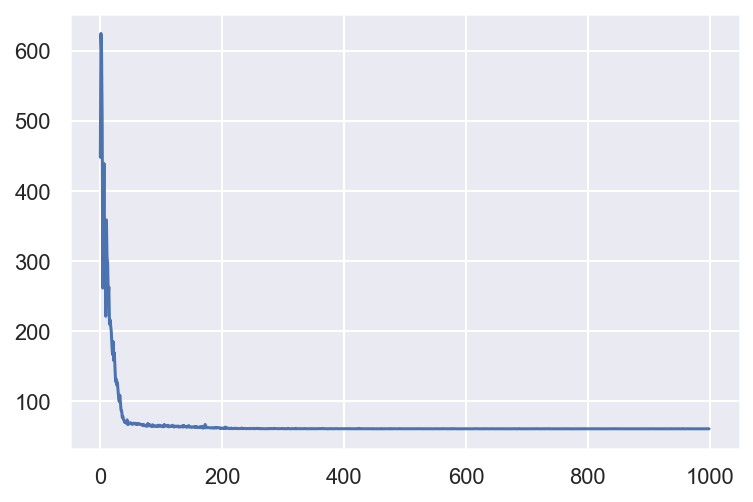

In [166]:
plt.plot(hist_loss);

In [167]:
with torch.no_grad():
    z0 = flow.sample_base_dist(1000)  
    zk, prior_logprob, log_det = flow(z0)
mu_samples, log_var_samples = zk.T

In [168]:
def plot_results(mu_samples, log_var_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha=0.3):
    
    true_log_var = np.log(true_sigma**2)
    obs_log_var = np.log(obs_sigma**2)
    
    sigma_samples = torch.exp(0.5*log_var_samples)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.set_title("Unconstrained space")
    ax.scatter(mu_samples, log_var_samples, alpha=alpha, color="C1")
    ax.scatter(true_mu, true_log_var, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_log_var, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\ln \sigma^2$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100)
    
    true_theta = torch.tensor([true_mu, true_log_var])
    pdf_true = likelihood(true_theta, x).exp()
    pdf_sample = likelihood(zk[:100].T, x).exp()

    ax.plot(x, pdf_sample, color="C1", alpha=0.25, label='inferred')
    ax.plot(x, pdf_true, color='C0', label="theoretic")
#     ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
#             color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

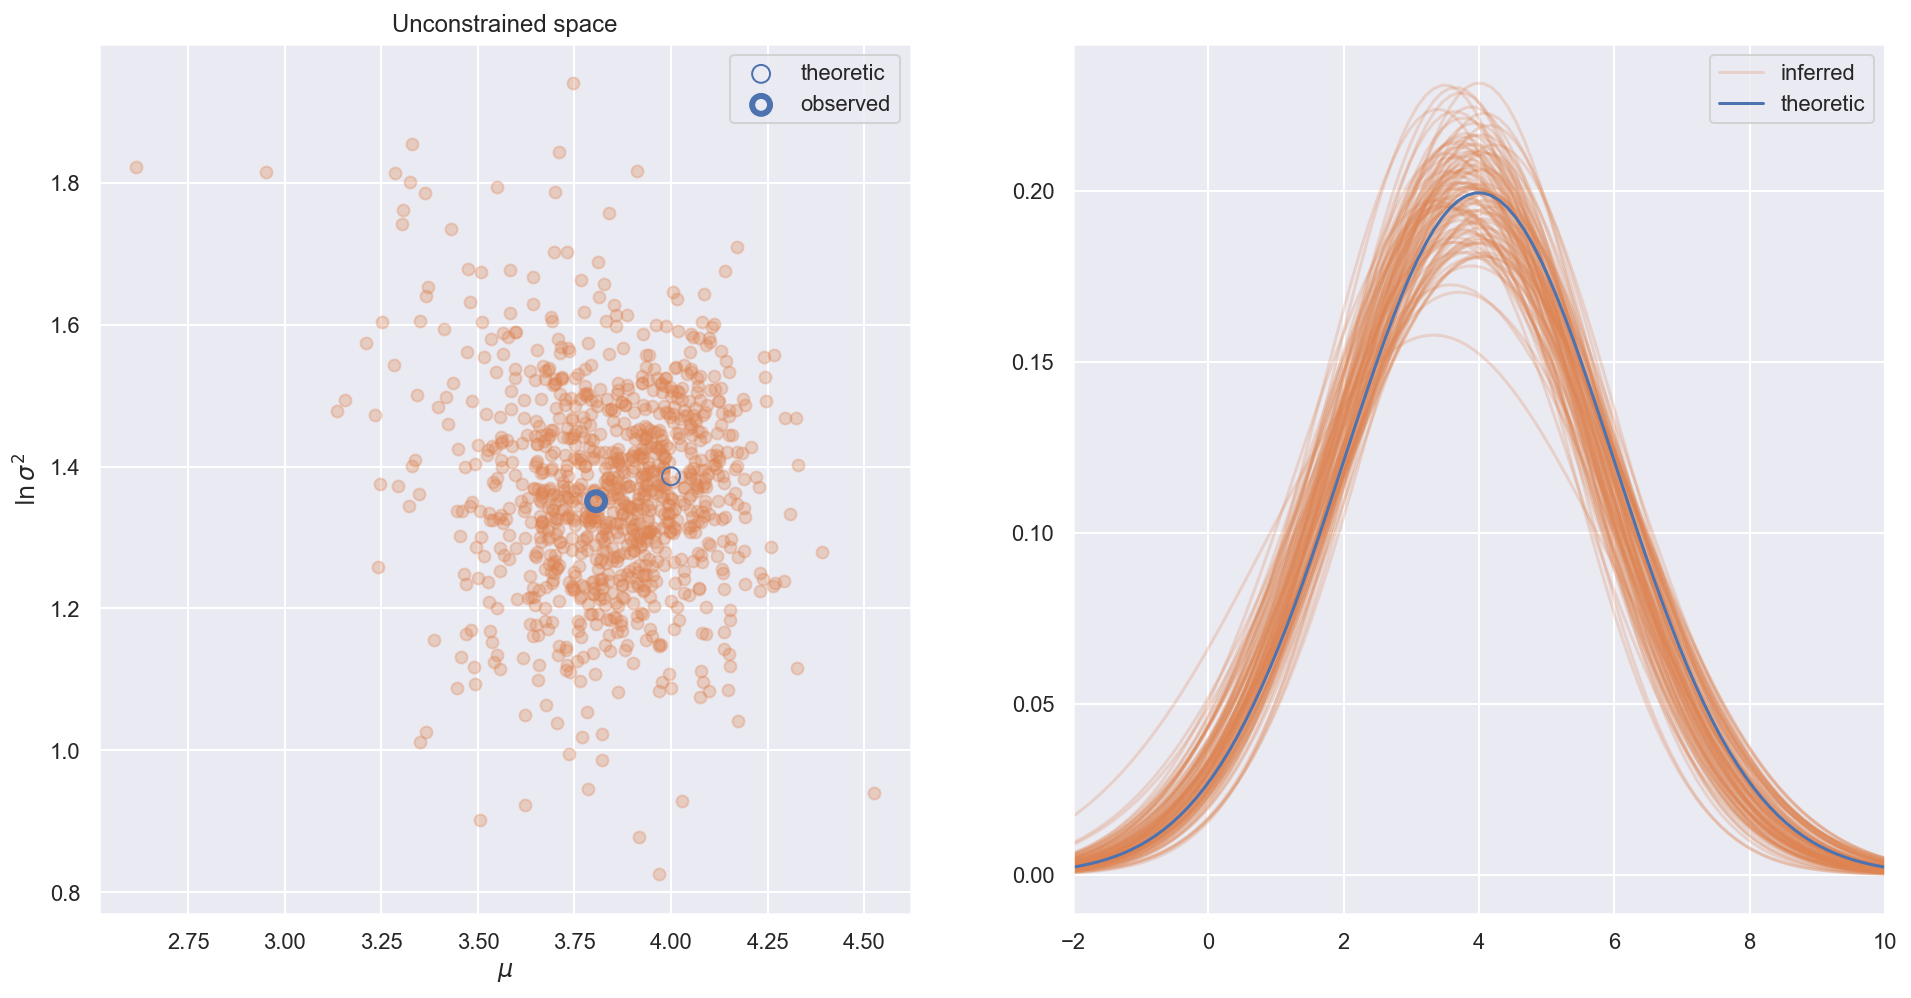

In [169]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

# Minibatch

In [171]:
batch_size = 10
epochs=10000

flow_length=16 
initial_lr = 0.01
n_sample = 40
freq_update_loss = 50
          
flow = NormalizingFlow(dim=n_dim, flow_length=flow_length)

loss_func = Loss()

optimizer = optim.Adam(
    flow.parameters(),
    lr=initial_lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

hist_loss = np.zeros(epochs)

with tqdm(total=epochs) as pbar:

    for epoch in range(epochs):
        
        permutation = torch.randperm(n_obs)
        
        for i in range(0, n_obs, batch_size):

            indices = permutation[i:i+batch_size]
            
            batch = obs[indices]
            optimizer.zero_grad()
            loss = loss_func(flow=flow,
                             obs=batch,
                             likelihood=likelihood,
                             n_sample=n_sample)
            loss.backward()
            optimizer.step()
            # scheduler.step()

        hist_loss[epoch] = loss.item()

        if epoch % freq_update_loss == 0 and epoch > 0:
            pbar.set_postfix(
                {'loss': np.mean(hist_loss[epoch - freq_update_loss:epoch])})
        pbar.update()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [144]:
with torch.no_grad():
    z0 = flow.sample_base_dist(1000)  
    zk, prior_logprob, log_det = flow(z0)
mu_samples, log_var_samples = zk.T

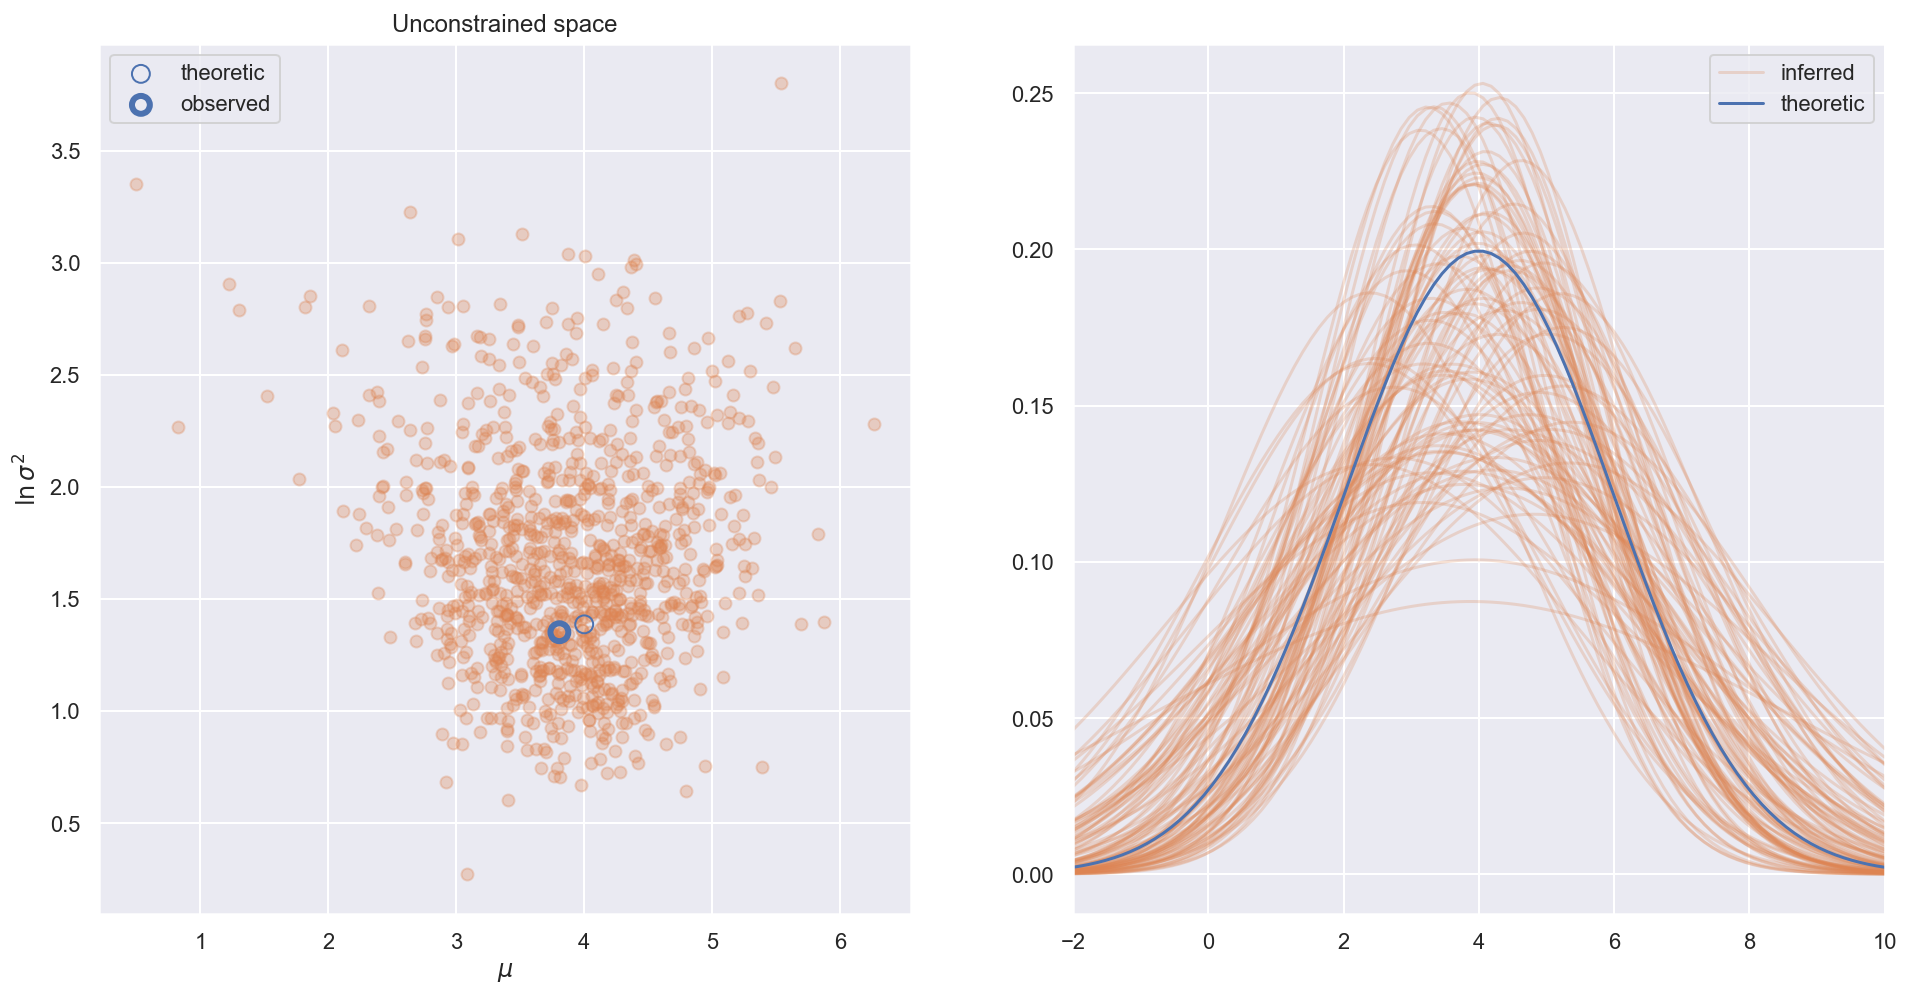

In [145]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

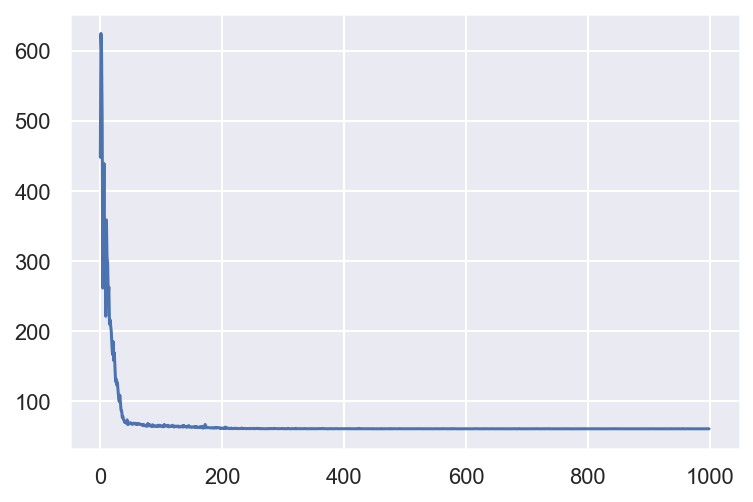

In [170]:
plt.plot(hist_loss);